In [1]:
import sys
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
sys.path.append(".") # To include Haisu module from local dir
from Haisu import HAISU 
import networkx as nx

mpi = 1 # NOTE: change this to the desired number of threads

### Create Simple Disconnected Graph:

In [2]:
clusters = [2,4,9,11,7,10]
clusters_str = list(map(str,clusters))
ajmatrix = np.zeros(shape=(len(clusters), len(clusters)))
ddict = dict(zip(clusters,range(len(clusters))))

ajmatrix[ddict[4]][ddict[11]] = 1 # connect clusters 4 and 11
ajmatrix[ddict[11]][ddict[2]] = 1 # connect clusters 4 and 11
ajmatrix[ddict[11]][ddict[7]] = 1 # connect clusters 4 and 11
ajmatrix[ddict[7]][ddict[10]] = 1 # connect clusters 7 and 10

ddict # Display cluster-to-index mapping

{2: 0, 4: 1, 9: 2, 11: 3, 7: 4, 10: 5}

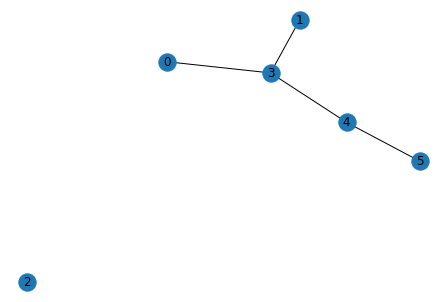

In [3]:
labeldict={}
graph_labels = clusters_str
graph = nx.from_numpy_matrix(ajmatrix)

# Dictionary from labels:
cnt = 0
for label in graph_labels:
    labeldict[sys.intern(label)] = cnt; cnt+=1

cnt = 0; glabels={}
for label in labeldict:
    glabels[cnt] = str(cnt)
    cnt+=1
nx.draw(graph, labels = glabels)

# Note: see ddict for index mapping

### Create Data & Init Haisu Configurations:

In [4]:
# Parameters:
strength = 0.8
bTranspose = False
bNormalize = False
ncols = 1000
mpi = 16 # NOTE: Adjust this to number of cores

# Create Data (Demonstrational):
np.random.seed(0)
submatrix = np.random.rand(1000, ncols)
labels = [str(clusters[x]) for x in np.random.randint(low=0, high=len(clusters), size=ncols)]

In [5]:
# haisu - epidist mode
haisu0 = HAISU(clusters_str, ajmatrix,disconnected_dist=1, avoid_self=['9'])
haisu0.pathcache.round(2)

array([[0.  , 0.67, 0.67, 0.33, 0.67, 1.  ],
       [0.67, 0.  , 0.67, 0.33, 0.67, 1.  ],
       [0.67, 0.67, 1.  , 0.67, 0.67, 0.67],
       [0.33, 0.33, 0.67, 0.  , 0.33, 0.67],
       [0.67, 0.67, 0.67, 0.33, 0.  , 0.33],
       [1.  , 1.  , 0.67, 0.67, 0.33, 0.  ]])

In [6]:
# haisu - Inter-Cluster Mode (default)
# This is default haisu - does not penalize haisu modification distances between a class and itself
haisu = HAISU(clusters_str, ajmatrix,disconnected_dist=1, avoid_self=[])
haisu.pathcache.round(2)

array([[0.  , 0.67, 0.67, 0.33, 0.67, 1.  ],
       [0.67, 0.  , 0.67, 0.33, 0.67, 1.  ],
       [0.67, 0.67, 0.  , 0.67, 0.67, 0.67],
       [0.33, 0.33, 0.67, 0.  , 0.33, 0.67],
       [0.67, 0.67, 0.67, 0.33, 0.  , 0.33],
       [1.  , 1.  , 0.67, 0.67, 0.33, 0.  ]])

In [7]:
# haisu - avoid self : Intra-Cluster Mode
# This is the same as default haisu parameters but distances from a class to itself
  # is penalized to min(self_dist, 1) which distances using the heirarchy
haisu2 = HAISU(clusters_str, ajmatrix,disconnected_dist=1, avoid_self=clusters_str, self_dist=1)
haisu2.pathcache.round(2)

array([[1.  , 0.67, 0.67, 0.33, 0.67, 1.  ],
       [0.67, 1.  , 0.67, 0.33, 0.67, 1.  ],
       [0.67, 0.67, 1.  , 0.67, 0.67, 0.67],
       [0.33, 0.33, 0.67, 1.  , 0.33, 0.67],
       [0.67, 0.67, 0.67, 0.33, 1.  , 0.33],
       [1.  , 1.  , 0.67, 0.67, 0.33, 1.  ]])

In [8]:
# haisu - avoid self : Intra-Cluster Mode
# This is the same as default haisu parameters but distances from a class to itself
  # is penalized to min(self_dist, 1) which distances using the heirarchy
haisu3 = HAISU(clusters_str, ajmatrix,disconnected_dist=1, avoid_self=clusters_str, self_dist=0.5)
haisu3.pathcache.round(2)

array([[0.5 , 0.67, 0.67, 0.33, 0.67, 1.  ],
       [0.67, 0.5 , 0.67, 0.33, 0.67, 1.  ],
       [0.67, 0.67, 0.5 , 0.67, 0.67, 0.67],
       [0.33, 0.33, 0.67, 0.5 , 0.33, 0.67],
       [0.67, 0.67, 0.67, 0.33, 0.5 , 0.33],
       [1.  , 1.  , 0.67, 0.67, 0.33, 0.5 ]])

In [9]:
# Run HAISU
print('Get pairwise matrix...') 
X0 = haisu0.get_pairwise_matrix(submatrix, labels, factor=0.07, transpose=bTranspose, normalize=bNormalize, metric='euclidean', n_jobs=mpi)
X = haisu.get_pairwise_matrix(submatrix, labels, factor=0.07, transpose=bTranspose, normalize=bNormalize, metric='euclidean', n_jobs=mpi)
X2 = haisu2.get_pairwise_matrix(submatrix, labels, factor=0.6, transpose=bTranspose, normalize=bNormalize, metric='euclidean', n_jobs=mpi)
X3 = haisu3.get_pairwise_matrix(submatrix, labels, factor=0.2, transpose=bTranspose, normalize=bNormalize, metric='euclidean', n_jobs=mpi)

Get pairwise matrix...


### Display results for different NLDR Methods:

In [10]:
from sklearn.manifold import TSNE
X_embedded0 = TSNE(n_components=2, metric='precomputed',square_distances=True,learning_rate=800, random_state=32, perplexity=25, n_jobs=mpi).fit_transform(X0)
X_embedded = TSNE(n_components=2, metric='precomputed',square_distances=True,learning_rate=800, random_state=32, perplexity=13, n_jobs=mpi).fit_transform(X)
X_embedded2 = TSNE(n_components=2, metric='precomputed',square_distances=True,learning_rate=800, random_state=32, perplexity=50, n_jobs=mpi).fit_transform(X2)
X_embedded3 = TSNE(n_components=2, metric='precomputed',square_distances=True,learning_rate=800, random_state=32, perplexity=50, n_jobs=mpi).fit_transform(X3)
X_embedded_raw = TSNE(n_components=2,square_distances=True,learning_rate=800, random_state=32, perplexity=200, n_jobs=mpi).fit_transform(submatrix)

/home2/s189220/.conda/envs/tsne/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-11-547900c2d096>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


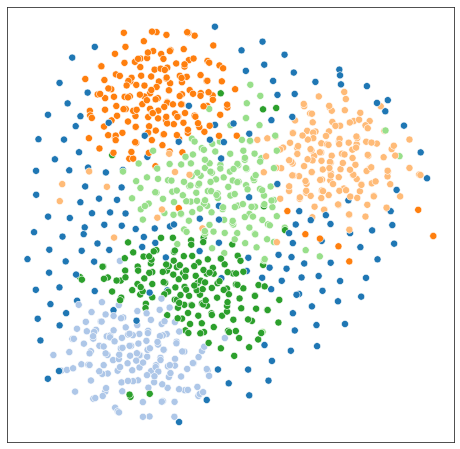

/home2/s189220/.conda/envs/tsne/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-11-547900c2d096>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


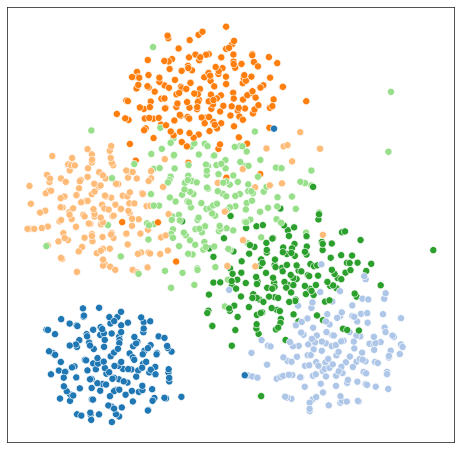

/home2/s189220/.conda/envs/tsne/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-11-547900c2d096>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


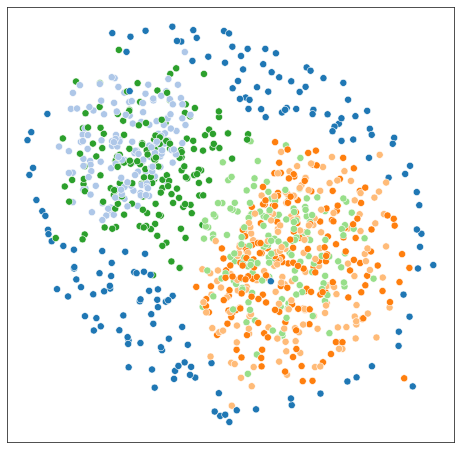

/home2/s189220/.conda/envs/tsne/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-11-547900c2d096>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


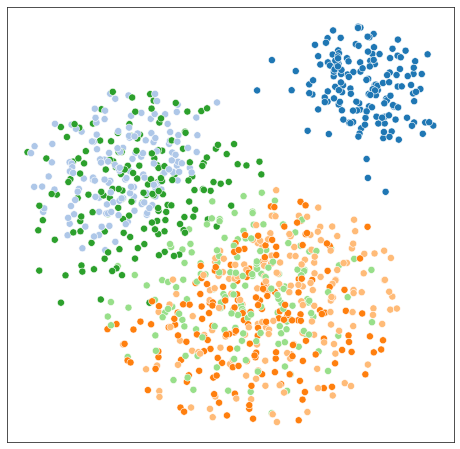

/home2/s189220/.conda/envs/tsne/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-11-547900c2d096>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


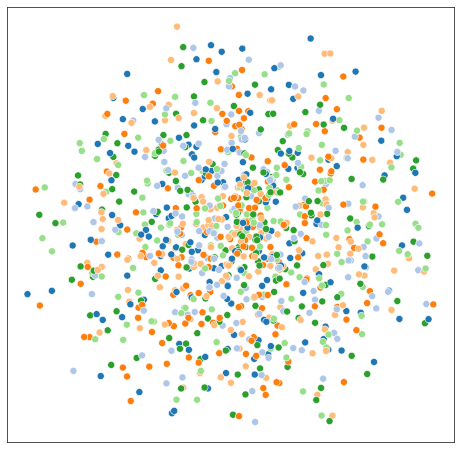

/home2/s189220/.conda/envs/tsne/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-11-547900c2d096>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


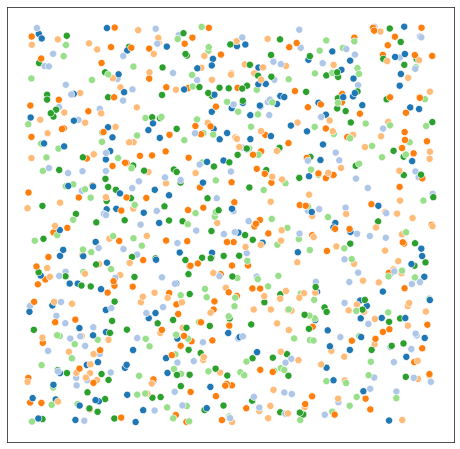

In [11]:
import pandas as pd; import seaborn as sns; import glob
import matplotlib.pyplot as plt; import pickle
import math; import numpy as np

data = [X_embedded0, X_embedded, X_embedded2, X_embedded3,X_embedded_raw, submatrix]
names = ['avoid_disconnected','default','avoid_self','mixed','tsne_raw','raw'] 

cnt=0
for d in data:
    plt.close('all')
    sns.set_style(style='white', rc={'figure.figsize':(8,8)})
    s = 50
    fig = sns.scatterplot(d[:,0], d[:,1], legend='full', alpha=1,hue=labels,s=s,palette='tab20',
                         hue_order=['9','10','2','4','7','11'])
    fig.get_legend().remove()
    fig.axis('tight')
    fig.set_xticklabels([])
    fig.set_yticklabels([])
    fig = fig.get_figure()
    fig.set_figwidth(8)
    fig.set_figheight(8)
    #fig.savefig(str('random_'+names[cnt])+'_haisu.png', dpi=300,pad_inches=0,bbox_inches='tight')
    fig.show()
    plt.show()
    cnt+=1

In [12]:
import umap
from sklearn.manifold import TSNE
import phate

In [13]:
reducer0 = umap.UMAP(metric='precomputed',init='random',n_neighbors=50,min_dist=0.3)
reducer = umap.UMAP(metric='precomputed',init='random',n_neighbors=50,min_dist=0.3)
reducer2 = umap.UMAP(metric='precomputed',init='random',n_neighbors=25, min_dist=1)
reducer3 = umap.UMAP(metric='precomputed',init='random',n_neighbors=50,min_dist=0.3)
reducer_raw = umap.UMAP(metric='precomputed',init='random',n_neighbors=50,min_dist=0.3)
X_embedded0 = reducer0.fit(X0).embedding_
X_embedded = reducer.fit(X).embedding_
X_embedded2 = reducer2.fit(X2).embedding_
X_embedded3 = reducer3.fit(X3).embedding_
X_embedded_raw = reducer_raw.fit(submatrix).embedding_

/home2/s189220/.conda/envs/tsne/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home2/s189220/.conda/envs/tsne/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)
/home2/s189220/.conda/envs/tsne/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home2/s189220/.conda/envs/tsne/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/hom

In [14]:
reducer_raw = umap.UMAP(init='random',n_neighbors=50,min_dist=0.3)
X_embedded_raw = reducer_raw.fit(submatrix).embedding_

/home2/s189220/.conda/envs/tsne/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-15-203e994a882a>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


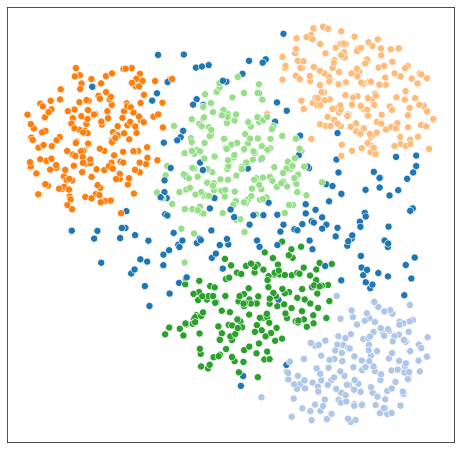

/home2/s189220/.conda/envs/tsne/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-15-203e994a882a>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


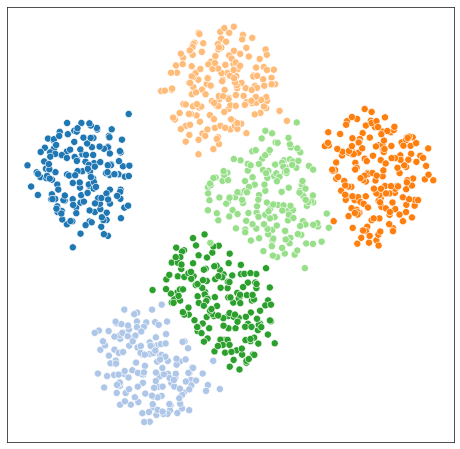

/home2/s189220/.conda/envs/tsne/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-15-203e994a882a>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


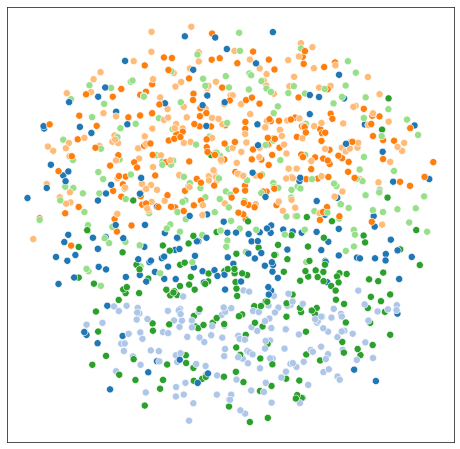

/home2/s189220/.conda/envs/tsne/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-15-203e994a882a>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


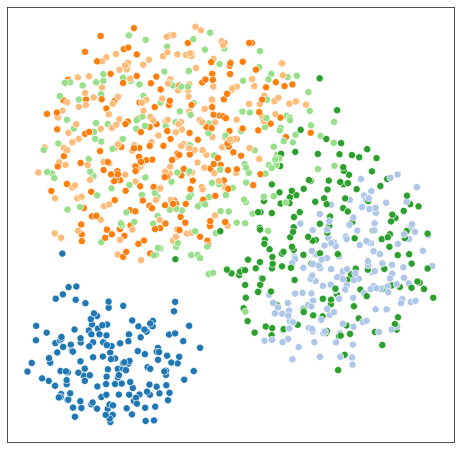

/home2/s189220/.conda/envs/tsne/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-15-203e994a882a>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


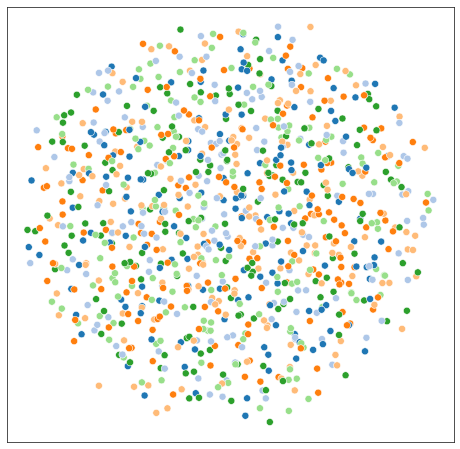

/home2/s189220/.conda/envs/tsne/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-15-203e994a882a>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


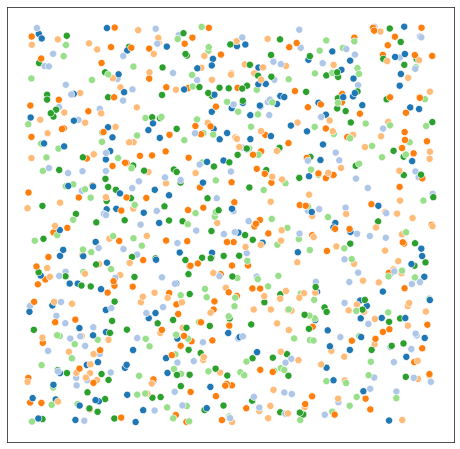

In [15]:
import pandas as pd; import seaborn as sns; import glob
import matplotlib.pyplot as plt; import pickle
import math; import numpy as np

data = [X_embedded0, X_embedded, X_embedded2, X_embedded3,X_embedded_raw, submatrix]
names = ['avoid_disconnected','default','avoid_self','mixed','umap_raw','raw'] 

cnt=0
for d in data:
    plt.close('all')
    sns.set_style(style='white', rc={'figure.figsize':(8,8)})
    s = 50
    fig = sns.scatterplot(d[:,0], d[:,1], legend='full', alpha=1,hue=labels,s=s,palette='tab20',
                         hue_order=['9','10','2','4','7','11'])
    fig.get_legend().remove()
    fig.axis('tight')
    fig.set_xticklabels([])
    fig.set_yticklabels([])
    fig = fig.get_figure()
    fig.set_figwidth(8)
    fig.set_figheight(8)
    #fig.savefig(str('random_umap_'+names[cnt])+'_haisu.png', dpi=300,pad_inches=0,bbox_inches='tight')
    fig.show()
    plt.show()
    cnt+=1

#fig.savefig(f'KNNdist_cardiac_{num_k}.png',dpi=300)
#fig.savefig(f'KNN{dset}.png',dpi=300)

In [16]:
X_str0 = haisu.get_pairwise_matrix(submatrix, labels, factor=0, transpose=bTranspose, normalize=bNormalize, metric='euclidean', n_jobs=mpi)

In [17]:
decay= 200
knn= 4

reducer0 = phate.PHATE(knn_dist='precomputed',n_jobs=mpi,n_components=2, decay=decay, knn=knn)
reducer = phate.PHATE(knn_dist='precomputed',n_jobs=mpi,n_components=2, decay=decay, knn=3)
reducer2 = phate.PHATE(knn_dist='precomputed',n_jobs=mpi,n_components=2, decay=200, knn=6)#,t=10)#300,8
reducer3 = phate.PHATE(knn_dist='precomputed',n_jobs=mpi,n_components=2, decay=decay, knn=8)#,t=24)#10
reducer_raw = phate.PHATE(n_jobs=mpi,n_components=2, decay=600, knn=3)
X_embedded0 = reducer0.fit_transform(X0)
X_embedded = reducer.fit_transform(X)
X_embedded2 = reducer2.fit_transform(X2)
X_embedded3 = reducer3.fit_transform(X3)
X_embedded_raw = reducer_raw.fit_transform(X_str0)

Calculating PHATE...
  Running PHATE on precomputed distance matrix with 1000 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
    Calculated affinities in 0.10 seconds.
  Calculated graph and diffusion operator in 0.11 seconds.
  Calculating optimal t...
    Automatically selected t = 18
  Calculated optimal t in 0.80 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.09 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.78 seconds.
Calculated PHATE in 1.79 seconds.
Calculating PHATE...
  Running PHATE on precomputed distance matrix with 1000 observations.
  Calculating graph and diffusion operator...
    Calculating affinities...
    Calculated affinities in 0.09 seconds.
  Calculated graph and diffusion operator in 0.10 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 0.55 seconds.
  Calculating diffusion potential...
  Calculated diffusion potentia

/home2/s189220/.conda/envs/tsne/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-18-9096c623b652>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


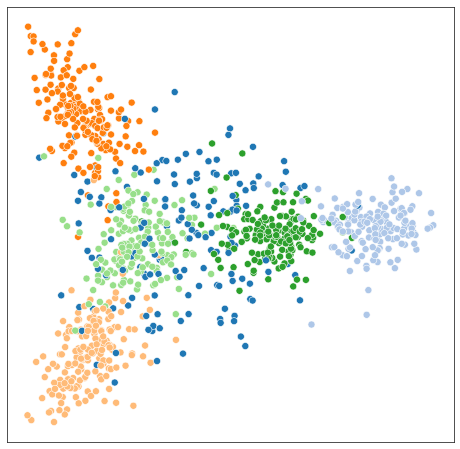

/home2/s189220/.conda/envs/tsne/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-18-9096c623b652>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


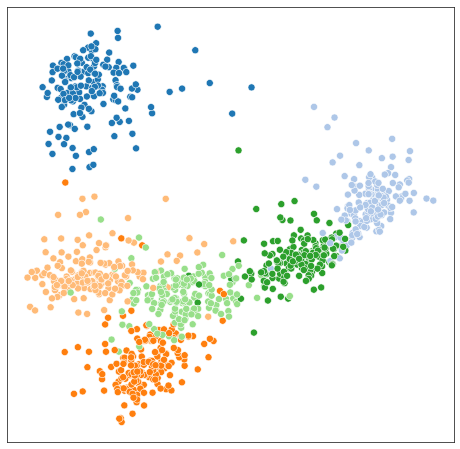

/home2/s189220/.conda/envs/tsne/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-18-9096c623b652>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


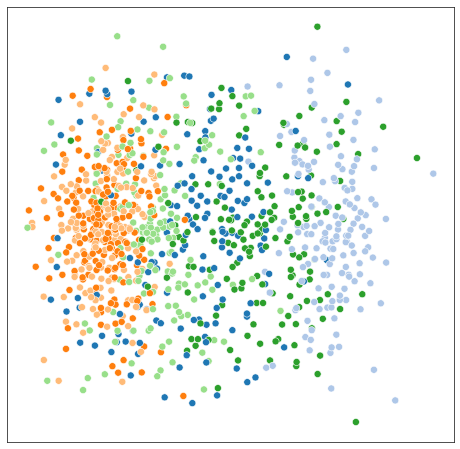

/home2/s189220/.conda/envs/tsne/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-18-9096c623b652>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


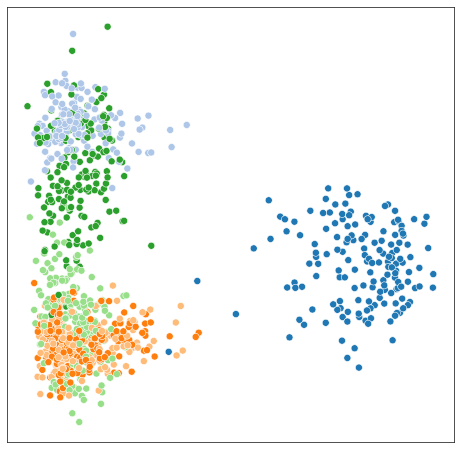

/home2/s189220/.conda/envs/tsne/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-18-9096c623b652>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


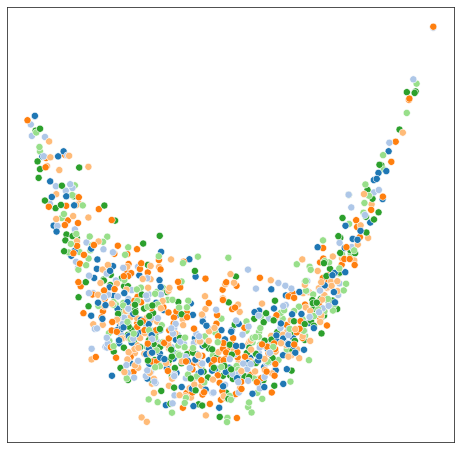

/home2/s189220/.conda/envs/tsne/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-18-9096c623b652>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


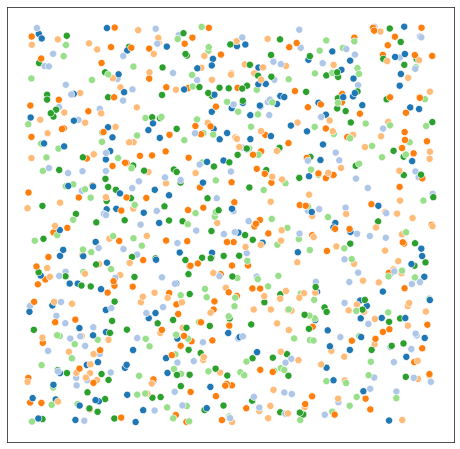

In [18]:
import pandas as pd; import seaborn as sns; import glob
import matplotlib.pyplot as plt; import pickle
import math; import numpy as np

data = [X_embedded0, X_embedded, X_embedded2, X_embedded3,X_embedded_raw, submatrix]
names = ['avoid_disconnected','default','avoid_self','mixed','phate_raw','raw'] 

cnt=0
for d in data:
    plt.close('all')
    sns.set_style(style='white', rc={'figure.figsize':(8,8)})
    s = 50
    fig = sns.scatterplot(d[:,0], d[:,1], legend='full', alpha=1,hue=labels,s=s,palette='tab20',
                         hue_order=['9','10','2','4','7','11'])
    fig.get_legend().remove()
    fig.axis('tight')
    fig.set_xticklabels([])
    fig.set_yticklabels([])
    fig = fig.get_figure()
    fig.set_figwidth(8)
    fig.set_figheight(8)
    #fig.savefig(str('random_phate_ALT_'+names[cnt])+'_haisu.png', dpi=300,pad_inches=0,bbox_inches='tight')
    fig.show()
    plt.show()
    cnt+=1